# Задание

Сверточный автоэнкодер для сжатия и восстановления изображений.

ДЗ 2. Вариант 1. Нужно выполнить:

1.разработать сверточный автоэнкодер, способный эффективно сжимать изображения и восстанавливать их с минимальными потерями качества;

2.провести анализ на изображениях.

Датасет "Фрукты и овощи" (для определения свежести фруктов и овощей):

https://www.kaggle.com/datasets/muhriddinmuxiddinov/fruits-and-vegetables-dataset

# Импорт библиотек и загрузка данных

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras_tuner import HyperModel, RandomSearch
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical


import cv2
from google.colab import drive

from PIL import Image

from multiprocessing import Pool

import matplotlib.pyplot as plt

In [3]:
# Подключаем Google Диск
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Создание DataFrame с изображениями из выбранных папок

# Указываем путь к папке на Google Диске
data_dir = '/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_2/Fruits_Vegetables_Dataset(12000)'

# Функция для получения путей к изображениям и их меток
def get_image_paths_and_labels(folder, label, valid_folders):
    image_paths = []
    labels = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                # Проверяем, что изображение находится в одной из нужных папок
                if any(valid_folder in root for valid_folder in valid_folders):
                    img_path = os.path.join(root, file)
                    image_paths.append(img_path)
                    labels.append(label)
    return image_paths, labels

# Перечисляем нужные папки
valid_fruit_folders = ['FreshApple', 'FreshBanana', 'FreshMango', 'FreshOrange', 'FreshStrawberry']
valid_vegetable_folders = ['FreshBellpepper', 'FreshCarrot', 'FreshCucumber', 'FreshPotato', 'FreshTomato']

# Получение путей к изображениям и их меток для папок "Fruits" и "Vegetables"
fruits_folder = os.path.join(data_dir, 'Fruits')
vegetables_folder = os.path.join(data_dir, 'Vegetables')

fruits_paths, fruits_labels = get_image_paths_and_labels(fruits_folder, 'Fruit', valid_fruit_folders)
vegetables_paths, vegetables_labels = get_image_paths_and_labels(vegetables_folder, 'Vegetable', valid_vegetable_folders)

# Объединение путей и меток в один список
all_paths = fruits_paths + vegetables_paths
all_labels = fruits_labels + vegetables_labels

# Создание DataFrame
df = pd.DataFrame({
    'image_path': all_paths,
    'label': all_labels
})

print(df.head())

                                          image_path  label
0  /content/drive/MyDrive/DS_Belhard_2/Homeworks/...  Fruit
1  /content/drive/MyDrive/DS_Belhard_2/Homeworks/...  Fruit
2  /content/drive/MyDrive/DS_Belhard_2/Homeworks/...  Fruit
3  /content/drive/MyDrive/DS_Belhard_2/Homeworks/...  Fruit
4  /content/drive/MyDrive/DS_Belhard_2/Homeworks/...  Fruit


In [5]:
# Проверка количества уникальных папок
unique_folders = df['image_path'].apply(lambda x: os.path.basename(os.path.dirname(x))).unique()
print(f"Количество уникальных папок: {len(unique_folders)}")
print(f"Уникальные папки: {unique_folders}")

Количество уникальных папок: 10
Уникальные папки: ['FreshMango' 'FreshOrange' 'FreshApple' 'FreshBanana' 'FreshStrawberry'
 'FreshBellpepper' 'FreshTomato' 'FreshCarrot' 'FreshPotato'
 'FreshCucumber']


# Предобработка данных

In [6]:
# Функция для загрузки и преобразования изображений в массивы numpy
def load_and_preprocess_image(img_path):
    img = Image.open(img_path).resize((128, 128))
    img_array = np.array(img).astype('float32') / 255.0
    # Проверка, что изображение имеет три цветовых канала
    if img_array.shape == (128, 128, 3):
        return img_array
    else:
        return None

# Функция для параллельной обработки
def parallel_process(paths, func, n_jobs=4):
    with Pool(n_jobs) as pool:
        results = pool.map(func, paths)
    return results

# Загрузка и нормализация всех изображений параллельно
image_arrays = parallel_process(df['image_path'], load_and_preprocess_image)
# Удаление None значений из списка
image_arrays = [img for img in image_arrays if img is not None]

# Преобразование image_arrays к numpy массиву
x_train = np.array(image_arrays)

print(f'x_train shape: {x_train.shape}')

x_train shape: (6070, 128, 128, 3)


Размеры (128, 128, 3) означают, что изображения имеют ширину 128 пикселей, высоту 128 пикселей и 3 цветовых канала. Эти три канала представляют собой красный (R), зеленый (G) и синий (B) цвета, которые вместе образуют цветное изображение в формате RGB.

In [7]:
print(x_train.shape)

(6070, 128, 128, 3)


# Моделирование и обучение c подбором гиперпараметров

In [8]:
# Определение гипермодели
class AutoencoderHyperModel(HyperModel):
    def build(self, hp):
        input_img = Input(shape=(128, 128, 3))

        # Кодировщик
        x = Conv2D(hp.Int('filters_1', min_value=8, max_value=64, step=8), (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(hp.Int('filters_2', min_value=8, max_value=64, step=8), (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(hp.Int('filters_3', min_value=8, max_value=64, step=8), (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

        # Декодировщик
        x = Conv2D(hp.Int('filters_3', min_value=8, max_value=64, step=8), (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(hp.Int('filters_2', min_value=8, max_value=64, step=8), (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(hp.Int('filters_1', min_value=8, max_value=64, step=8), (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
        return autoencoder

# Настройка гиперпараметров
hypermodel = AutoencoderHyperModel()
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='autoencoder_tuning'
)

# Обучение модели с подбором гиперпараметров
tuner.search(x_train, x_train, epochs=100, batch_size=256, validation_split=0.2)

Trial 10 Complete [00h 02m 52s]
val_loss: 0.48741862177848816

Best val_loss So Far: 0.48691946268081665
Total elapsed time: 00h 23m 58s


In [12]:
# Получение лучших гиперпараметров
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Лучшие гиперпараметры: {best_hps.values}")
# Лучшие гиперпараметры: {'filters_1': 56, 'filters_2': 24, 'filters_3': 56}

Лучшие гиперпараметры: {'filters_1': 56, 'filters_2': 24, 'filters_3': 56}


In [13]:
# Обучение модели с лучшими гиперпараметрами
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, x_train, epochs=1000, batch_size=256, validation_split=0.2)

Epoch 1/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step - loss: 0.6828 - val_loss: 0.5805
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.6164 - val_loss: 0.5444
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.5751 - val_loss: 0.5199
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.5602 - val_loss: 0.5125
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.5557 - val_loss: 0.5092
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.5517 - val_loss: 0.5062
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.5508 - val_loss: 0.5025
Epoch 8/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.5485 - val_loss: 0.4995
Epoch 9/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.5427 - val_loss: 0.4985
Epoch 10/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.5461 - val_loss: 0.4979
Epoch 11/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.5429 - val_loss: 0.4961
Epoch 12/1000
19/19 ━━━━━━━━━━━━━━━━━━━━

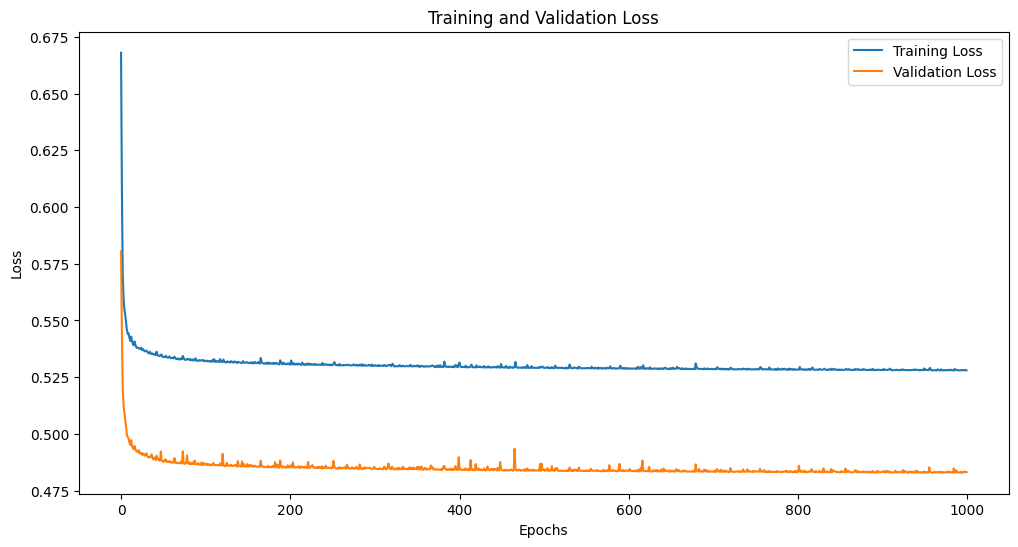

In [14]:
# Построение графика потерь
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Проверка на тестовых данных

In [15]:
# Проверка на тестовых данных
decoded_imgs = model.predict(x_train)

190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


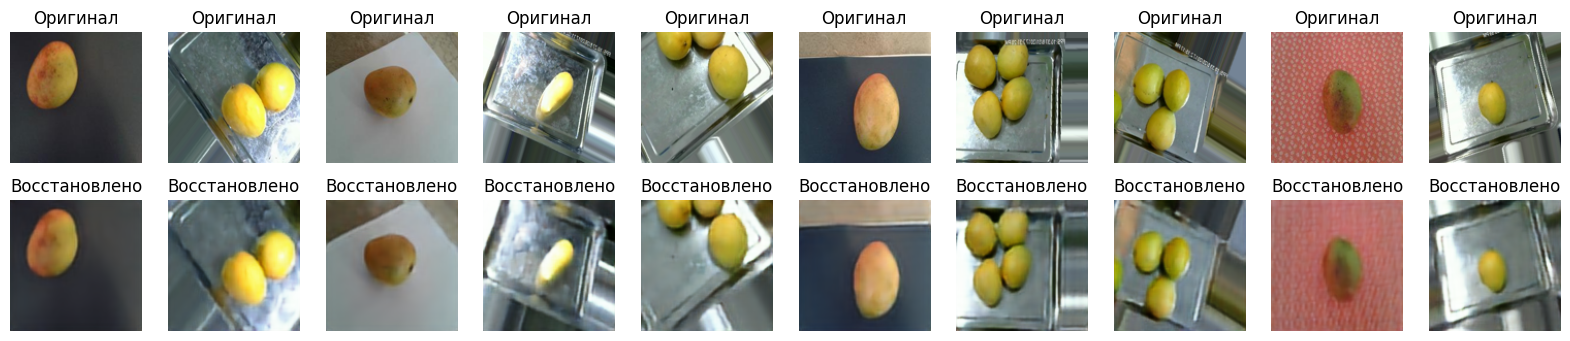

In [16]:
# Визуализация результатов
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Оригинальные изображения
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(128, 128, 3))
    plt.title("Оригинал")
    plt.axis('off')

    # Восстановленные изображения
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128, 3))
    plt.title("Восстановлено")
    plt.axis('off')
plt.show()

# Использование модели

In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка и предсказание для новой картинки
def predict_new_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Изображение не загружено. Проверьте путь к файлу: {image_path}")

    img = cv2.resize(img, (128, 128))
    img = img.astype('float32') / 255.
    img = np.reshape(img, (1, 128, 128, 3))
    decoded_img = model.predict(img)

    # Отображение оригинального и восстановленного изображения
    plt.figure(figsize=(10, 4))
    # Оригинальное изображение
    ax = plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img.reshape(128, 128, 3), cv2.COLOR_BGR2RGB))
    plt.title("Оригинал")
    plt.axis('off')

    # Восстановленное изображение
    ax = plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(decoded_img.reshape(128, 128, 3), cv2.COLOR_BGR2RGB))
    plt.title("Восстановлено")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


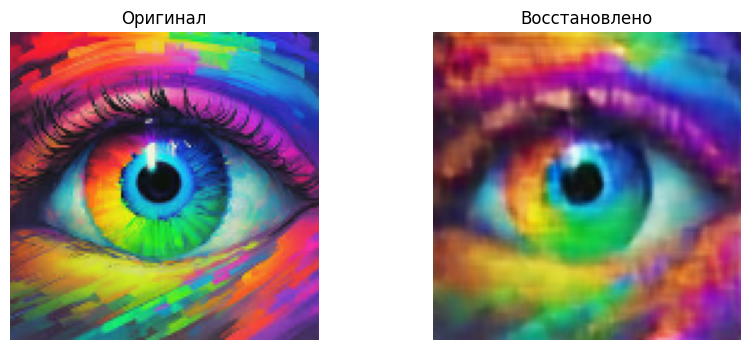

In [68]:
# Пример использования функции
predict_new_image('drive/MyDrive/DS_Belhard_2/Homeworks/HW_2/image_1.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


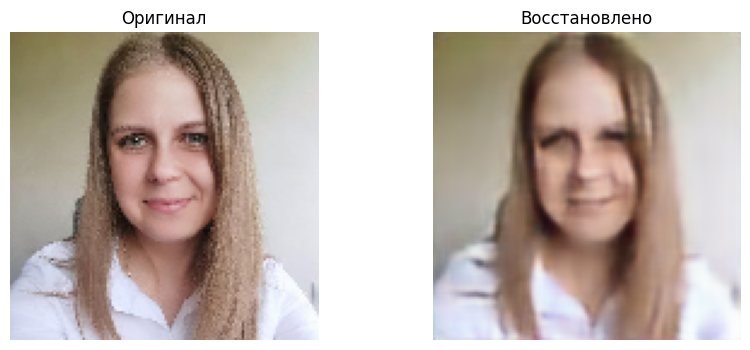

In [70]:
# Пример использования функции
predict_new_image('drive/MyDrive/DS_Belhard_2/Homeworks/HW_2/image_3.jpg')